## Training potential model types on test data

## Based on non-exhaustive research, it appears a few of the most used methods are XGBoost (Extreme Gradient Boosting), Generalized Linear Model, Random Forest Regressor.

### Links
#### KTH Royal Inst. of Tech (Sweden) - Comp. of XGBoost and Random Forest on housing data
https://www.diva-portal.org/smash/get/diva2:1597534/FULLTEXT01.pdf

#### NYU Dis. comparing GLM and RF on housing data, RF ended up with lower error.
https://cs.nyu.edu/media/publications/lowrance_roy.pdf

#### Comparing algorithms for housing predictions
https://www.mdpi.com/2073-445X/11/11/2100/pdf

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
# Import Data
sf_df = pd.read_csv("../First Segment Rubric - Sample Data/sf_clean.csv")
sf_df.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7.0
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7.0
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7.0


In [5]:
# Drop 'hood_district'
sf_df = sf_df.drop(columns='hood_district',axis=1)

In [6]:
# Inspect data types
sf_df.dtypes

price             int64
sqft            float64
beds            float64
bath            float64
laundry          object
pets             object
housing_type     object
parking          object
dtype: object

In [7]:
# List categorical variables
sf_cat = sf_df.dtypes[sf_df.dtypes == "object"].index.tolist()

In [8]:
# Encode cat. variables
enc = OneHotEncoder(sparse=False)

sf_encode = pd.DataFrame(enc.fit_transform(sf_df[sf_cat]))

sf_encode.columns = enc.get_feature_names_out(sf_cat)
sf_encode.head()

,laundry_(a) in-unit,laundry_(b) on-site,laundry_(c) no laundry,pets_(a) both,pets_(b) dogs,pets_(c) cats,pets_(d) no pets,housing_type_(a) single,housing_type_(b) double,housing_type_(c) multi,parking_(a) valet,parking_(b) protected,parking_(c) off-street,parking_(d) no parking
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [9]:
# Merge sf_df and sf_encode
sf_df = sf_df.merge(sf_encode, left_index=True, right_index=True)
sf_df = sf_df.drop(columns=sf_cat, axis=1)
sf_df.head()

,price,sqft,beds,bath,laundry_(a) in-unit,laundry_(b) on-site,laundry_(c) no laundry,pets_(a) both,pets_(b) dogs,pets_(c) cats,pets_(d) no pets,housing_type_(a) single,housing_type_(b) double,housing_type_(c) multi,parking_(a) valet,parking_(b) protected,parking_(c) off-street,parking_(d) no parking
0,6800,1600.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,3500,550.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,5100,1300.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,9000,3500.0,3.0,2.5,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,3100,561.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [10]:
# Remove target
y = sf_df['price'].values
X = sf_df.drop(columns=['price'], axis=1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [11]:
# Scale the training data
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Lightly tweaked Gradient Boosting Regressor (scikit-learn's implementation of Extreme Gradient Boosting)

In [13]:
# Create Gradient Boosting Regressor Tree
gbr = GradientBoostingRegressor(max_depth=2, n_estimators=500, random_state=42)

In [14]:
# Fit to training data
gbr.fit(X_train_scaled, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=500, random_state=42)

In [15]:
# Calc. error vals in predictions
errors = [mean_squared_error(y_test, y_pred)
         for y_pred in gbr.staged_predict(X_test_scaled)]

In [16]:
# Determine best number of estimators
best_n_estimators = np.argmin(errors) + 1

Text(200, 1000000.0, 'Best number of estimators: 180')

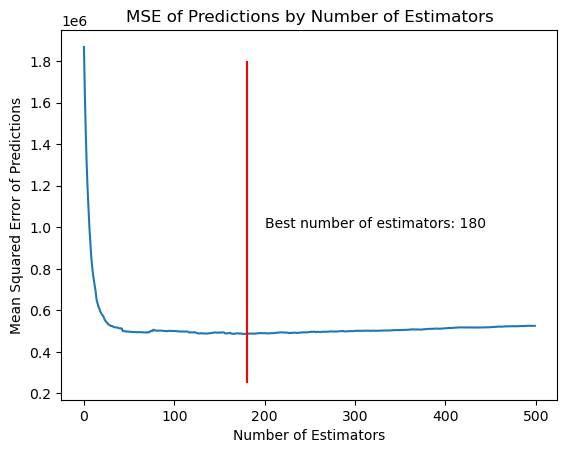

In [17]:
plt.plot(range(0,500),errors)
plt.vlines(np.argmin(errors)+1,0.25e6,1.8e6,color='r')
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Squared Error of Predictions")
plt.title("MSE of Predictions by Number of Estimators")
plt.text(200,1e6,f'Best number of estimators: {best_n_estimators}')

In [18]:
# Train GBRT based on new n_estimators

gbr = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators, random_state=42)


gbr.fit(X_train_scaled, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=180, random_state=42)

In [19]:
# Display Score
print(f'Training Score: {gbr.score(X_train_scaled, y_train)}')
print(f'Testing Score: {gbr.score(X_test_scaled, y_test)}')

Training Score: 0.8812233586888314
Testing Score: 0.7738799433073498


### Short GridSearchCV tuning of GBR

In [40]:
# Params to test
params = {
    'n_estimators':[50,100,150,200],
    'learning_rate':[.0001,.001,.01,.1],
    'max_depth':[1,2,3,4],
    'subsample':[.5,.75,1],
    'random_state':[42]
}

In [45]:
# Initialize new GBR
gbr2 = GradientBoostingRegressor()

# Create Object with results of CV
searcher = GridSearchCV(estimator=gbr2,param_grid=params,scoring='neg_mean_squared_error',n_jobs=-1)

In [46]:
# Fit to training data
searcher.fit(X_train_scaled, y_train)

GridSearchCV(estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1],
                         'max_depth': [1, 2, 3, 4],
                         'n_estimators': [50, 100, 150, 200],
                         'random_state': [42], 'subsample': [0.5, 0.75, 1]},
             scoring='neg_mean_squared_error')

In [50]:
searcher.best_params_

{'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 200,
 'random_state': 42,
 'subsample': 0.5}

In [54]:
gbrCV = GradientBoostingRegressor(learning_rate=0.1,
 max_depth = 2,
 n_estimators = 200,
 random_state = 42,
 subsample = 0.5)

gbrCV.fit(X_train_scaled, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42,
                          subsample=0.5)

In [55]:
# Display Score
print(f'Training Score: {gbrCV.score(X_train_scaled, y_train)}')
print(f'Testing Score: {gbrCV.score(X_test_scaled, y_test)}')

Training Score: 0.8976606946378511
Testing Score: 0.7450757755608984


## Basic Generalized Linear Model with Tweedie distribution

In [20]:
from sklearn.linear_model import TweedieRegressor
tr = TweedieRegressor(power=1.5, alpha=.1)

In [21]:
tr.fit(X_train_scaled, y_train)

TweedieRegressor(alpha=0.1, power=1.5)

In [64]:
# Display Score
print(f'Training Score: {tr.score(X_train_scaled, y_train)}')
print(f'Testing Score: {tr.score(X_test_scaled, y_test)}')

Training Score: 0.8015202915165338
Testing Score: 0.7555993795256601


## Random Forest Regressor

In [26]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(max_depth=2, n_estimators=180, random_state=42)

In [27]:
rfr.fit(X_train_scaled,y_train)

RandomForestRegressor(max_depth=2, n_estimators=180, random_state=42)

In [28]:
# Display Score
print(f'Training Score: {rfr.score(X_train_scaled, y_train)}')
print(f'Testing Score: {rfr.score(X_test_scaled, y_test)}')

Training Score: 0.7124126097860604
Testing Score: 0.6889877058455537


### Short GridSearchCV tuning of RFR

In [92]:
# Params to test
params_rfr = {
    'n_estimators':[50,100,150,200],
    'max_depth':[1,2,3,4],
    'max_leaf_nodes':[8,16,32,64],
    'max_features':[1,'sqrt','log2'],
    'random_state':[42]
}

In [95]:
# Initialize new RFR
rfr2 = RandomForestRegressor()

# Create Object with results of CV
searcher_rfr = GridSearchCV(estimator=rfr2,param_grid=params_rfr,scoring='neg_mean_squared_error',n_jobs=-1)

In [96]:
searcher_rfr.fit(X_train_scaled, y_train)

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4],
                         'max_features': [1, 'sqrt', 'log2'],
                         'max_leaf_nodes': [8, 16, 32, 64],
                         'n_estimators': [50, 100, 150, 200],
                         'random_state': [42]},
             scoring='neg_mean_squared_error')

In [97]:
searcher_rfr.best_params_

{'max_depth': 4,
 'max_features': 'sqrt',
 'max_leaf_nodes': 16,
 'n_estimators': 150,
 'random_state': 42}

In [98]:
rfrCV = RandomForestRegressor(max_depth=4, max_features='sqrt',max_leaf_nodes=16,
                              n_estimators=150, random_state=42)

rfrCV.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=4, max_features='sqrt', max_leaf_nodes=16,
                      n_estimators=150, random_state=42)

In [99]:
# Display Score
print(f'Training Score: {rfrCV.score(X_train_scaled, y_train)}')
print(f'Testing Score: {rfrCV.score(X_test_scaled, y_test)}')

Training Score: 0.7809570673161385
Testing Score: 0.7160236499364789


### Other Linear Models

In [39]:
from sklearn.linear_model import LassoCV

In [40]:
lasso = LassoCV(cv=5, random_state=42)

In [41]:
lasso.fit(X_train_scaled,y_train)

LassoCV(cv=5, random_state=42)

In [51]:
lasso.alpha_

37.36128962265786

In [42]:
# Display Score
print(f'Training Score: {lasso.score(X_train_scaled, y_train)}')
print(f'Testing Score: {lasso.score(X_test_scaled, y_test)}')

Training Score: 0.7392578184534317
Testing Score: 0.7468475034281833


In [52]:
from sklearn.linear_model import ElasticNetCV

In [53]:
enet = ElasticNetCV(cv=5, random_state=42)

In [54]:
enet.fit(X_train_scaled,y_train)

ElasticNetCV(cv=5, random_state=42)

In [55]:
# Display Score
print(f'Training Score: {enet.score(X_train_scaled, y_train)}')
print(f'Testing Score: {enet.score(X_test_scaled, y_test)}')

Training Score: 0.6343265792143804
Testing Score: 0.6692000044288597


In [59]:
from sklearn.linear_model import RidgeCV

In [61]:
ridge = RidgeCV(cv=5)

In [62]:
ridge.fit(X_train_scaled,y_train)

RidgeCV(cv=5)

In [63]:
# Display Score
print(f'Training Score: {ridge.score(X_train_scaled, y_train)}')
print(f'Testing Score: {ridge.score(X_test_scaled, y_test)}')

Training Score: 0.7425217321919939
Testing Score: 0.7479707579315646


In [95]:
from sklearn.linear_model import RANSACRegressor

In [96]:
ransac = RANSACRegressor(random_state=42)

In [97]:
ransac.fit(X_train_scaled,y_train)

RANSACRegressor(random_state=42)

In [98]:
# Display Score
print(f'Training Score: {ransac.score(X_train_scaled, y_train)}')
print(f'Testing Score: {ransac.score(X_test_scaled, y_test)}')

Training Score: 0.6796714890063746
Testing Score: 0.7019876607247776


In [99]:
from sklearn.linear_model import HuberRegressor

In [101]:
huber = HuberRegressor()

In [102]:
huber.fit(X_train_scaled,y_train)

HuberRegressor()

In [103]:
# Display Score
print(f'Training Score: {huber.score(X_train_scaled, y_train)}')
print(f'Testing Score: {huber.score(X_test_scaled, y_test)}')

Training Score: 0.7295574922379199
Testing Score: 0.7438966144640918


### Example Stacking with Lasso, Ridge, and GBR.

In [89]:
from sklearn.ensemble import StackingRegressor
# Final Estimator.
from sklearn.linear_model import TheilSenRegressor

In [204]:
# Create list of estimator objects
estimators = [
    ('ridge', RidgeCV(cv=10)),
    ('lasso', LassoCV(cv=10, random_state=42)),
    ('gbr', GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators, random_state=42))
]

In [205]:
# Create Stacking Regressor with a final estimator.
stack = StackingRegressor(
estimators=estimators,
final_estimator=TheilSenRegressor(random_state=42), cv=15, n_jobs=-1)

In [206]:
stack.fit(X_train_scaled,y_train)

StackingRegressor(cv=15,
                  estimators=[('ridge', RidgeCV(cv=10)),
                              ('lasso', LassoCV(cv=10, random_state=42)),
                              ('gbr',
                               GradientBoostingRegressor(max_depth=2,
                                                         n_estimators=180,
                                                         random_state=42))],
                  final_estimator=TheilSenRegressor(random_state=42),
                  n_jobs=-1)

In [207]:
# Display Score
print(f'Training Score: {stack.score(X_train_scaled, y_train)}')
print(f'Testing Score: {stack.score(X_test_scaled, y_test)}')

Training Score: 0.7744758356260062
Testing Score: 0.7568832454660315
